# Example of generating a 1D2DRR model - an overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the Hydrolib environment.

This notebook is based on previous examples of the python package delft3dfmpy, but now connnected to the Hydrolib-core package, which is used for writing a D-Hydro model. It contains similar functinality as delft3dfmpy v2.0.1; input data is expected to be according to HyDAMO DAMO2.2 gpkg-format. The example model used here is based on a part of the Oostrumsche beek in Limburg, ameded with some fictional dummy data to better illustrate functionalities.

## Load Python libraries and Hydrolib-core functionality

In [2]:
# Basis
from pathlib import Path
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as cx
import os
import sys

In [3]:
## In not installed, add a path from where hydrolib it can be imported
#sys.path.insert(0, "d:/Documents/GitHub/HYDROLIB")
sys.path.insert(0, r"D:\3640.20\HYDROLIB-dhydamo")

# NOTE: core and dhydamo need to be in the same folder to be imported correctly
# and from hydrolib-core
from hydrolib.core.io.dimr.models import DIMR, FMComponent
from hydrolib.core.io.inifield.models import IniFieldModel
from hydrolib.core.io.onedfield.models import OneDFieldModel
from hydrolib.core.io.structure.models import *
from hydrolib.core.io.crosssection.models import *
from hydrolib.core.io.ext.models import ExtModel
from hydrolib.core.io.mdu.models import FMModel
from hydrolib.core.io.bc.models import ForcingModel
from hydrolib.core.io.friction.models import FrictionModel
from hydrolib.core.io.obs.models import ObservationPointModel

# Importing relevant classes from Hydrolib-dhydamo
from hydrolib.dhydamo.core.hydamo import HyDAMO
from hydrolib.dhydamo.converters.df2hydrolibmodel import Df2HydrolibModel
from hydrolib.dhydamo.geometry import mesh
from hydrolib.dhydamo.core.drr import DRRModel
from hydrolib.dhydamo.core.drtc import DRTCModel
from hydrolib.dhydamo.io.dimrwriter import DIMRWriter
from hydrolib.dhydamo.io.drrwriter import DRRWriter
from hydrolib.dhydamo.geometry.viz import plot_network

Define in- and output paths

In [4]:
# path to the package containing the dummy-data
data_path = Path("../tests/data").resolve()
assert data_path.exists()

# path to write the models
output_path = Path("../tests/model2").resolve()
# assert output_path.exists()

Define components that should be used in the model. 1D is used in all cases.

In [5]:
TwoD = True
RR = True
RTC = True

## Read HyDAMO DAMO2.2 data

In [6]:
# all data is contained in one geopackage called 'Example model'
gpkg_file = str(data_path / "Example_model.gpkg")

# initialize a hydamo object
hydamo = HyDAMO(extent_file=data_path / "OLO_stroomgebied_incl.maas.shp")

# show content
hydamo.branches.show_gpkg(gpkg_file)

Content of gpkg-file D:\3640.20\HYDROLIB-dhydamo\hydrolib\tests\data\Example_model.gpkg, containing 18 layers:
	INDEX	|	NAME                        	|	GEOM_TYPE      	|	 NFEATURES	|	   NFIELDS
	    0	|	hydroobject                   	|	Line String 	|	        61	|	        35
	    1	|	stuw                          	|	3D Point    	|	        25	|	        40
	    2	|	duikersifonhevel              	|	3D Line String	|	        92	|	        43
	    3	|	gemaal                        	|	3D Point    	|	         1	|	         8
	    4	|	brug                          	|	Point       	|	         1	|	        10
	    5	|	pomp                          	|	Unknown (any)	|	         1	|	         9
	    6	|	sturing                       	|	Unknown (any)	|	         3	|	        19
	    7	|	kunstwerkopening              	|	Unknown (any)	|	       213	|	        15
	    8	|	hydrologischerandvoorwaarde   	|	Point       	|	         1	|	         8
	    9	|	regelmiddel                   	|	3D Point    	|	        27	|	   

In [7]:
# read branchs
hydamo.branches.read_gpkg_layer(gpkg_file, layer_name="HydroObject", index_col="code")
# read profiles
hydamo.profile.read_gpkg_layer(
    gpkg_file,
    layer_name="ProfielPunt",
    groupby_column="profiellijnid",
    order_column="codevolgnummer",
    id_col="code",
)
hydamo.profile_roughness.read_gpkg_layer(gpkg_file, layer_name="RuwheidProfiel")
hydamo.profile.snap_to_branch(hydamo.branches, snap_method="intersecting")
hydamo.profile.dropna(axis=0, inplace=True, subset=["branch_offset"])
hydamo.profile_line.read_gpkg_layer(gpkg_file, layer_name="profiellijn")
hydamo.profile_group.read_gpkg_layer(gpkg_file, layer_name="profielgroep")
hydamo.profile.drop("code", axis=1, inplace=True)
hydamo.profile["code"] = hydamo.profile["profiellijnid"]
# structures
hydamo.culverts.read_gpkg_layer(gpkg_file, layer_name="DuikerSifonHevel", index_col="code")
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method="ends", maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=["branch_offset"])

hydamo.weirs.read_gpkg_layer(gpkg_file, layer_name="Stuw")
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method="overal", maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=["branch_offset"])
hydamo.opening.read_gpkg_layer(gpkg_file, layer_name="Kunstwerkopening")
hydamo.management_device.read_gpkg_layer(gpkg_file, layer_name="Regelmiddel")

idx = hydamo.management_device[hydamo.management_device["duikersifonhevelid"].notnull()].index
for i in idx:
    globid = hydamo.culverts[
        hydamo.culverts.code == hydamo.management_device.duikersifonhevelid.loc[i]
    ].globalid.values[0]
    hydamo.management_device.at[i, "duikersifonhevelid"] = globid

hydamo.pumpstations.read_gpkg_layer(gpkg_file, layer_name="Gemaal", index_col="code")
hydamo.pumpstations.snap_to_branch(hydamo.branches, snap_method="overal", maxdist=10)
hydamo.pumps.read_gpkg_layer(gpkg_file, layer_name="Pomp", index_col="code")
hydamo.management.read_gpkg_layer(gpkg_file, layer_name="Sturing", index_col="code")

hydamo.bridges.read_gpkg_layer(gpkg_file, layer_name="Brug", index_col="code")
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method="overal", maxdist=1100)
hydamo.bridges.dropna(axis=0, inplace=True, subset=["branch_offset"])
# boundaries
hydamo.boundary_conditions.read_gpkg_layer(
    gpkg_file, layer_name="hydrologischerandvoorwaarde", index_col="code"
)
hydamo.boundary_conditions.snap_to_branch(hydamo.branches, snap_method="overal", maxdist=10)

# catchments
hydamo.catchments.read_gpkg_layer(gpkg_file, layer_name="afvoergebiedaanvoergebied", index_col="code")
# laterals
hydamo.laterals.read_gpkg_layer(gpkg_file, layer_name="lateraleknoop")
for ind, cat in hydamo.catchments.iterrows():
    hydamo.catchments.loc[ind, "lateraleknoopcode"] = hydamo.laterals[
        hydamo.laterals.globalid == cat.lateraleknoopid
    ].code.values[0]
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method="overal", maxdist=5000)

15.0 is MultiPolygon; split into single parts.
57.0 is MultiPolygon; split into single parts.
68.0 is MultiPolygon; split into single parts.
71.0 is MultiPolygon; split into single parts.
92.0 is MultiPolygon; split into single parts.
285.0 is MultiPolygon; split into single parts.
310.0 is MultiPolygon; split into single parts.
882.0 is MultiPolygon; split into single parts.


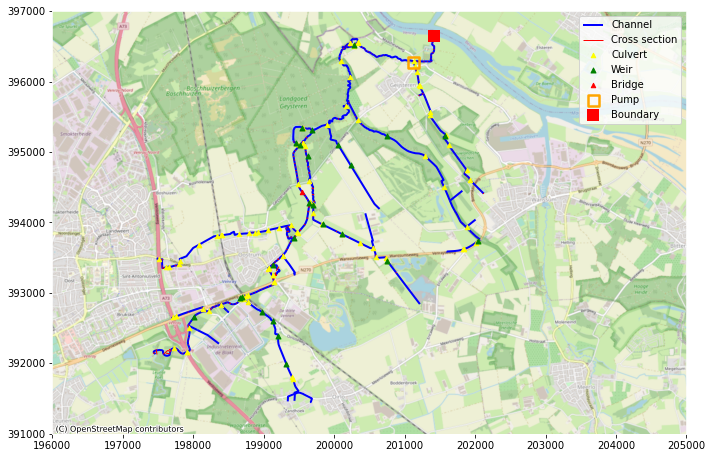

In [8]:
plt.rcParams["axes.edgecolor"] = "w"

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(196000, 205000)
ax.set_ylim(391000, 397000)

hydamo.branches.geometry.plot(ax=ax, label="Channel", linewidth=2, color="blue")
hydamo.profile.geometry.plot(ax=ax, color="red", label="Cross section", linewidth=1)
hydamo.culverts.geometry.centroid.plot(
    ax=ax, color="yellow", label="Culvert", markersize=20, zorder=10, marker="^"
)
hydamo.weirs.geometry.centroid.plot(ax=ax, color="green", label="Weir", markersize=25, zorder=10, marker="^")
hydamo.bridges.geometry.plot(ax=ax, color="red", label="Bridge", markersize=20, zorder=10, marker="^")
hydamo.pumpstations.geometry.plot(
    ax=ax,
    color="orange",
    label="Pump",
    marker="s",
    markersize=125,
    zorder=10,
    facecolor="none",
    linewidth=2.5,
)
hydamo.boundary_conditions.geometry.plot(
    ax=ax, color="red", label="Boundary", marker="s", markersize=125, zorder=10, facecolor="red", linewidth=0
)
ax.legend()

cx.add_basemap(ax, crs=28992, source=cx.providers.OpenStreetMap.Mapnik)
fig.tight_layout()

## Data conversion


### Structures

HyDAMO contains methods to convert HyDAMO2.2 data to internal dataframes, which correspond to the D-Hydro format.

We first import the structures from the HyDAMO-object, since the structures' positions are necessary for defining the position of the 1D-mesh. Structures can also be added without the HyDAMO imports. O

Note that for importing most structures multiple objects are needed from the GPKG. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found, the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section ('hydamo.profile') should be related through 'hydamo.profile_line' to a 'hydamo.profile_group', which contains a 'stuwid' column which is equal to the GlobalID of the corresponding weir. The weir object can also include orifices, in that case the field 'overlaatonderlaat' in the 'management_device-object ('regelmiddel') is 'onderlaat'. For weirs it should be 'overlaat'.
 
 - for culverts, a regelmiddel can be used to model a 'schuif' and/or a 'terugslagklep'. This is specified by the field 'soortregelmiddel'. In case of a 'terugslagklep', the flow direction is set to 'positive' instead of 'both'. In case of a 'schuif', a valve is implemented. Note that in DAMO2.2, an 'afsluitmiddel' can contain the same information. For now, only a regelmiddel (management_device) is implemented. In a next version, the flexibility to use both will be included. 
 
 - bridges need an associated crosssection. This is idential to universal weirs, but here the 'hydamo.profile_group'-object should contain a field 'brugid'. 
 
 - pumps are composed from 'hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement'. Only suction-side drection is implemented. Maximal capacity should be in m3/min.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects ('hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement');
- bridges really need an associated crosssection (see above);

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

In [9]:
hydamo.structures.convert.weirs(
    hydamo.weirs,
    hydamo.profile_group,
    hydamo.profile_line,
    hydamo.profile,
    hydamo.opening,
    hydamo.management_device,
)

hydamo.structures.convert.culverts(hydamo.culverts, management_device=hydamo.management_device)

hydamo.structures.convert.bridges(
    hydamo.bridges,
    profile_groups=hydamo.profile_group,
    profile_lines=hydamo.profile_line,
    profiles=hydamo.profile,
)

hydamo.structures.convert.pumps(hydamo.pumpstations, pumps=hydamo.pumps, management=hydamo.management)

Additional methods are available to add structures:

In [10]:
hydamo.structures.add_rweir(
    id="rwtest",
    name="rwtest",
    branchid="W_1386_0",
    chainage=2.0,
    crestlevel=18.0,
    crestwidth=3.0,
    corrcoeff=1.0,
)

The resulting dataframes look like this:

In [11]:
hydamo.structures.culverts_df.head()

,id,name,branchid,chainage,rightlevel,leftlevel,length,inletlosscoeff,outletlosscoeff,csdefid,bedfrictiontype,bedfriction,allowedflowdir,valveonoff,numlosscoeff,valveopeningheight,relopening,losscoeff
0,B_11954,None,W_2591_1,895.235,11.891157,11.891157,2.834944,0.5,1.0,B_11954,Manning,0.01667,both,0,None,0.0,None,None
1,B_11547,None,W_242225_0,158.537,12.736937,12.736937,0.953823,0.5,1.0,B_11547,Manning,0.01667,both,0,None,0.0,None,None
2,B_11546,None,W_242226_0,0.244,12.335174,12.335174,1.485853,0.5,1.0,B_11546,Manning,0.01667,both,0,None,0.0,None,None
3,B_11544,None,W_242224_0,775.644,13.107891,13.107891,2.610899,0.5,1.0,B_11544,Manning,0.01667,both,0,None,0.0,None,None
4,B_11548,None,W_242227_0,8.699,11.781898,11.781898,4.115577,0.5,1.0,B_11548,Manning,0.01667,both,0,None,0.0,None,None


# Initialize the FM-model

At this stage also the start and stoptime are defined, they will be used in the other modules if needed

In [12]:
fm = FMModel()
# Set start and stop time
fm.time.refdate = 20160601
fm.time.tstop = 2 * 3600 * 24

## Add the 1D mesh

The above structures are collected in one dataframe and in the generation of calculation poins, as structures should be separated by calculation points.

In [13]:
structures = hydamo.structures.as_dataframe(
    rweirs=True,
    bridges=True,
    uweirs=True,
    culverts=True,
    orifices=True,
    pumps=True,
)

In [14]:
mesh.mesh1d_add_branches_from_gdf(
    fm.geometry.netfile.network,
    branches=hydamo.branches,
    branch_name_col="code",
    node_distance=20,
    max_dist_to_struc=None,
    structures=structures,
)

Some structures are not linked to a branch.
Structures [22, 25] have the same location.
Structures [19, 28] have the same location.
Structures [27, 33] have the same location.


Add cross-sections to the branches. TO do this, many HyDAMO objects might be needed: if parameterised profiles occur, they are taken from hydamo.param_profile and, param_profile_values; if crosssections are associated with structures, those are specified in profile_group and profile lines. 

HyDAMO DAMO2.2 data contains two roughness values (high and low); here it can be specified which one to use.

For branches without a crosssection, a default profile can be defined.

In [15]:
hydamo.crosssections.convert.profiles(
    crosssections=hydamo.profile,
    crosssection_roughness=hydamo.profile_roughness,
    profile_groups=hydamo.profile_group,
    profile_lines=hydamo.profile_line,
    param_profile=hydamo.param_profile,
    param_profile_values=hydamo.param_profile_values,
    branches=hydamo.branches,
    roughness_variant="High",
)

# Set a default cross section
default = hydamo.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype="StricklerKs", roughnessvalue=30, name="default"
)
hydamo.crosssections.set_default_definition(definition=default, shift=10.0)

### Observation points

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates.

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore. Observation point coordinates can be definied eiher as an (x,y)-tuple or as a shapely Point-object.

In [16]:
hydamo.observationpoints.add_points(
    [Point((200200, 395600)), (200200, 396200)],
    ["ObsPt1", "ObsPt2"],
    locationTypes=["1d", "1d"],
    snap_distance=10.0,
)

### Storage nodes

In [17]:
hydamo.storagenodes.add_storagenode(
    "test",
    "123_123",
    usestreetstorage="true",
    nodetype="unspecified",
    name=np.nan,
    usetable="false",
    bedlevel=12.0,
    area=100,
    streetlevel=14.0,
    streetstoragearea=10.0,
    storagetype="reservoir",
    levels=np.nan,
    storagearea=np.nan,
    interpolate="linear",
)

### Boundary conditions

In [18]:
hydamo.external_forcings.convert.boundaries(hydamo.boundary_conditions, mesh1d=fm.geometry.netfile.network)

#### Add a fictional time series to use in the BC file

<AxesSubplot:>

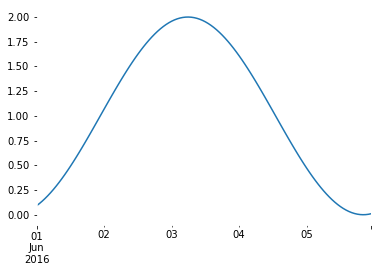

In [19]:
series = pd.Series(np.sin(np.linspace(2, 8, 120) * -1) + 1.0)
series.index = [pd.Timestamp("2016-06-01 00:00:00") + pd.Timedelta(hours=i) for i in range(120)]
series.plot()

There is also a fuction to convert laterals, but to run this we also need the RR model. Therefore, see below. It also possible to manually add boundaries and laterals as constants or timeseries. We implement the sinoid above as an upstream streamflow boundary and a lateral:

In [20]:
hydamo.external_forcings.add_boundary_condition(
    "RVW_01", (197464.0, 392130.0), "dischargebnd", series, fm.geometry.netfile.network
)

In [21]:
hydamo.dict_to_dataframe(hydamo.external_forcings.boundary_nodes)

,id,quantity,value,time,time_unit,value_unit,nodeid
RVM_02,RVM_02,waterlevelbnd,11.0,None,minutes since 0000-00-00 00:00:00,m,201414.562000_396649.200000
RVW_01,RVW_01,dischargebnd,"[0.09070257317431829, 0.11283143771052084, 0.1...","[0.0, 60.0, 120.0, 180.0, 240.0, 300.0, 360.0,...",minutes since 2016-06-01 00:00:00,m3/s,197462.792000_392131.096000


### Initial conditions

Set the initial water depth to 0.5 m. It is also possible to set a global water level using the equivalent function "set_initial_waterlevel".

In [22]:
hydamo.external_forcings.set_initial_waterdepth(1.5)

### 2D mesh

To add a mesh, currently 2 options exist:
1. The converter can generate a relatively simple mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

    - Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
    - Refine along the main branch
    - Determine altitude from a DEM. 


In [23]:
# 2d mesh extent
if TwoD:
    extent = gpd.read_file(r"..\tests\data\2D_extent.shp").at[0, "geometry"]
    network = fm.geometry.netfile.network

To generate a triangular mesh:

In [24]:
#if TwoD:
    #mesh.mesh2d_add_triangular(network, extent, edge_length=50.0)

And a rectangular mesh:

In [25]:
if TwoD:
    mesh.mesh2d_add_rectilinear(network, extent, dx=50, dy=50)

In [26]:
if TwoD:
    print("Nodes before refinement:", network._mesh2d.mesh2d_node_x.size)

    # refine around the branches. This does only work for a polygon without holes, so use the exterior
    buffer = Polygon(hydamo.branches.buffer(50.0).unary_union.exterior)
    mesh.mesh2d_refine(network, buffer, 1)
    print("Nodes after refinement:", network._mesh2d.mesh2d_node_x.size)

    # add terrain level
    mesh.mesh2d_altitude_from_raster(network, "../tests/data/rasters/AHN_2m_clipped_filled.tif", "face", "mean", fill_value=-999)

Nodes before refinement: 7515
Nodes after refinement: 11945


For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==True).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

### Add 1d-2d links

In [27]:
if TwoD:
    mesh.links1d2d_add_links_1d_to_2d(fm.geometry.netfile.network)

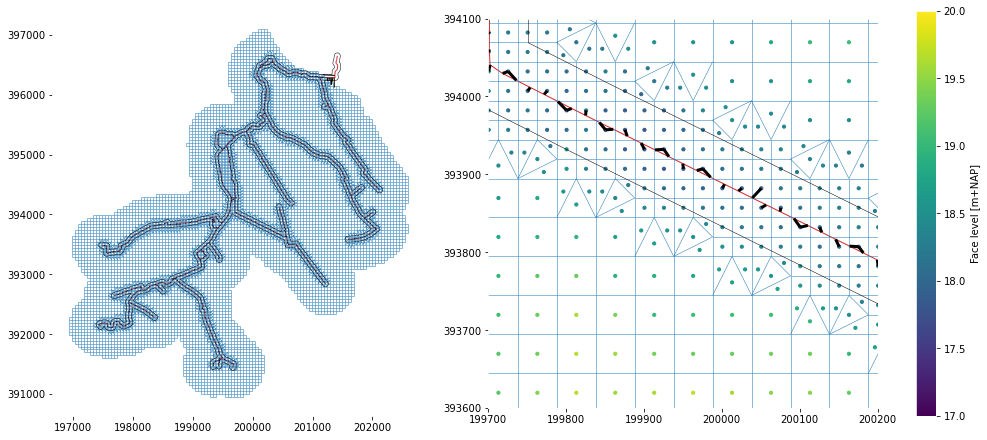

In [28]:
if TwoD:
    network = fm.geometry.netfile.network
    fig, axs = plt.subplots(figsize=(13.5, 6), ncols=2, constrained_layout=True)
    plot_network(network, ax=axs[0])
    plot_network(network, ax=axs[1], links1d2d_kwargs=dict(lw=3, color="k"))
    for ax in axs:
        ax.set_aspect(1.0)
        ax.plot(*buffer.exterior.coords.xy, color="k", lw=0.5)
    axs[0].autoscale_view()
    axs[1].set_xlim(199700, 200200)
    axs[1].set_ylim(393600, 394100)

    sc = axs[1].scatter(
        x=network._mesh2d.mesh2d_face_x,
        y=network._mesh2d.mesh2d_face_y,
        c=network._mesh2d.mesh2d_face_z,
        s=10,
        vmin=17,
        vmax=20,
    )
    cb = plt.colorbar(sc, ax=axs[1])
    cb.set_label("Face level [m+NAP]")

    plt.show()

For finalizing the FM-model, we also need the coupling to the other modules. Therefore, we will do that first.

# Add an RTC model

RTC contains many different options. Three are now implemented in D-HyDAMO: 
- a PID controller (crest level is determined by water level at an observation point);
- a time controller (a time series of crest level is provided);
- the possibility for the users to provide their own XML-files for more complex cases. Depending on the complexity, the integration might not yet work for all cases.

First, initialize a DRTCModel-object. The input is hydamo (for the data), fm (for the time settings), a path where the model will be created (typically an 'rtc' subfolder), a timestep (default 60 seconds) and, optionally, a folder where the user can put 'custom' XML code that will be integrated in the RTC-model. These files will be parsed now and be integrated later.

In [29]:
if RTC:
    drtcmodel = DRTCModel(
        hydamo,
        fm,
        output_path=output_path,
        rtc_timestep=60.0,
        complex_controllers_folder=data_path / "complex_controllers"        
    )

If PID controllers are present, they need settings that are not included in the HyDAMO DAMO2.2 data. We define those in a dictionary. They can be specified for each structure - in that case the key of the dictionary should match the key in the HyDAMO DAMO2.2 'sturing'-object. If no separate settings are provided the 'global' settings are used.

In [30]:
if RTC:
    pid_settings = {}
    pid_settings["global"] = {
        "ki": -0.05,
        "kp": -0.03,
        "kd": 0.0,
        "maxspeed": 0.00033,
    }
    pid_settings["kst_pid"] = {
            "ki": -0.03,
            "kp": -0.0,
            "kd": 0.0,
            "maxspeed": 0.00033,
        }

The function 'from_hydamo' converts the controllers that are specified in the HyDAMO DAMO2.2 data. The extra input consists of the settings for PID controllers (see above) and a dataframe with time series for the time controllers.

In [31]:
if RTC:
    if not hydamo.management.typecontroller.empty:
        timeseries = pd.read_csv(data_path / "timecontrollers.csv")
        timeseries.index = timeseries.Time        

        drtcmodel.from_hydamo(pid_settings=pid_settings, timeseries=timeseries)

Additional controllers, that are not included in D-HyDAMO DAMO2.2 might be specified like this:

In [32]:
if RTC:
    drtcmodel.add_pid_controller(
        structure_id="S_96788",
        steering_variable="Crest level (s)",
        target_variable="Water level (op)",
        setpoint=18.2,
        observation_location="ObsPt2",
        lower_bound=18.0,
        upper_bound=18.4,
        pid_settings=pid_settings["global"],
    )

    drtcmodel.add_time_controller(
        structure_id="S_96548", steering_variable="Crest level (s)", data=timeseries.iloc[:,1]
    )

Note that the provided complex controllers use observation points that are not yet in the model. As opposed to delft3dfmpy, it is now possible to add observation points in stages. So we add the missing point now:

In [33]:
hydamo.observationpoints.add_points(
    [Point(201200, 396750)], ["ObsPt3"], locationTypes=["1d"], snap_distance=1000.0
)

## Add a rainfall runoff model

RR has not changed yet compared to delft3dfmpy. Initialize a model:

In [34]:
if RR:
    drrmodel = DRRModel()

Catchments are provided in the HyDAMO DAMO2.2 format and included in the GPKG. They can also be read from other formats using 'read_gml', or 'read_shp'. Note that in case of shapefiles column mapping is necessary because the column names are truncated. 

Note that when catchments have a "MultiPolygon' geometry, the multipolygons are 'exploded' into single polygon geometries. A warning of this is isued, and a suffix is added to every polygons ID to prevent duplicates. 

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.
 
At the moment, two options exist for the schematisation of the paved area:
 1) simple: the paved fraction of each catchment is modelled with a paved node, directly connected to catchments' boundary node
 <br>
 2) more complex: sewer area polygons and overflow points are used a input as well. For each sewer area, the overlapping paved area is the distributed over the overflows that are associated with the sewerarea (the column 'lateraleknoopcode') using the area fraction (column 'fractie') for each overflow. In each catchment, paved area that does not intersect with a sewer area gets an unpaved node as in option (1).


Load data and settings (still to fill with documentatation from delft3dfmpy)

In [35]:
if RR:
    # all data and settings to create the RR-model
    lu_file = data_path / "rasters" / "sobek_landuse.tif"
    ahn_file = data_path / "rasters" / "AHN_2m_clipped_filled.tif"
    soil_file = data_path / "rasters" / "sobek_soil.tif"
    surface_storage = 10.0
    infiltration_capacity = 100.0
    initial_gwd = 1.2  # water level depth below surface

    runoff_resistance = 1.0
    infil_resistance = 300.0
    layer_depths = [0.0, 1.0, 2.0]
    layer_resistances = [30, 200, 10000]
    street_storage = 10.0
    sewer_storage = 10.0
    pumpcapacity = 10.0
    roof_storage = 10.0
    meteo_areas = hydamo.catchments

Fill the nodes:

For land use and soil type a coding is prescribed. For landuse, the legend of the map is expected to be as follows: <br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in m+NAP.

In [36]:
if RR:
    drrmodel.unpaved.io.unpaved_from_input(
        hydamo.catchments,
        lu_file,
        ahn_file,
        soil_file,
        surface_storage,
        infiltration_capacity,
        initial_gwd,
        meteo_areas,
    )
    drrmodel.unpaved.io.ernst_from_input(
        hydamo.catchments,
        depths=layer_depths,
        resistance=layer_resistances,
        infiltration_resistance=infil_resistance,
        runoff_resistance=runoff_resistance,
    )
    drrmodel.paved.io.paved_from_input(
        catchments=hydamo.catchments,
        landuse=lu_file,
        surface_level=ahn_file,
        street_storage=street_storage,
        sewer_storage=sewer_storage,
        pump_capacity=pumpcapacity,
        meteo_areas=meteo_areas,
        zonalstats_alltouched=True,
    )
    drrmodel.greenhouse.io.greenhouse_from_input(
        hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas, zonalstats_alltouched=True
    )
    drrmodel.openwater.io.openwater_from_input(
        hydamo.catchments, lu_file, meteo_areas, zonalstats_alltouched=True
    )

Make the RR boundaries:

In [37]:
if RR:
    drrmodel.external_forcings.io.boundary_from_input(hydamo.laterals, hydamo.catchments, drrmodel)

Again, the result is a dictionary, but it can be easily displayed as a dataframe:

In [38]:
if RR:
    hydamo.dict_to_dataframe(drrmodel.paved.pav_nodes).tail()

As with FM objects, also RR-nodes can be added from the workflow. An unpaved node as an example:

In [39]:
if RR:
    drrmodel.paved.add_paved(
        id="test_pav",
        area="100",
        surface_level="18.1",
        street_storage="10.0",
        sewer_storage="10.0",
        pump_capacity="1.",
        meteo_area=hydamo.catchments.iloc[0].code,
        px=str(hydamo.catchments.iloc[0].geometry.centroid.coords[0][0]),
        py=str(hydamo.catchments.iloc[0].geometry.centroid.coords[0][1]),
        boundary_node=list(drrmodel.external_forcings.boundary_nodes.keys())[0],
    )

### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

Precipitation and evaporation are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved. For seepage, as the use of Metaswap-rasters is allowed, the unit is assumed to m3/grid cell/timestep.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.

IMPORTANT: time steps are extracted from the file names. Therefore, the names should cohere to some conditions:
The filename should consist of at least two parts, separated by underscores. The second part needs to contain time information, which should be formatted as YYYYMMDDHHMMSS (SS may be omitted). Or, for daily data YYYYMMDD.

For example: 'precip_20200605151500.tif'

Extracting meteo-data from rasters can be time consuming. If precip_file and evap_file are specified, meteo-files are copied from an existing location.

In [40]:
if RR:
    seepage_folder = data_path / "rasters" / "seepage"
    precip_file = str(data_path / "DEFAULT.BUI")
    evap_folder = data_path / "rasters" / "evaporation"
    drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
    drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder=None, precip_file=precip_file)
    drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder=evap_folder, evap_file=None)

Reading seepage files:   0%|          | 0/3 [00:00<?, ?it/s]

Reading evaporation files:   0%|          | 0/3 [00:00<?, ?it/s]

Add the main parameters:

In [41]:
if RR:   
    drrmodel.d3b_parameters["Timestepsize"] = 300
    drrmodel.d3b_parameters["StartTime"] = "'2016/06/01;00:00:00'"  # should be equal to refdate for D-HYDRO
    drrmodel.d3b_parameters["EndTime"] = "'2016/06/03;00:00:00'"
    drrmodel.d3b_parameters["RestartIn"] = 0
    drrmodel.d3b_parameters["RestartOut"] = 0
    drrmodel.d3b_parameters["RestartFileNamePrefix"] = "Test"
    drrmodel.d3b_parameters["UnsaturatedZone"] = 1
    drrmodel.d3b_parameters["UnpavedPercolationLikeSobek213"] = -1
    drrmodel.d3b_parameters["VolumeCheckFactorToCF"] = 100000


And now we can also add the laterals to FM with the correct settings:

In [42]:
if RR:
    hydamo.external_forcings.convert.laterals(
        hydamo.laterals,
        lateral_discharges=None,
        rr_boundaries=drrmodel.external_forcings.boundary_nodes,
    )
else:
    lateral_discharges = hydamo.laterals["afvoer"]
    lateral_discharges.index = hydamo.laterals.code
    hydamo.external_forcings.convert.laterals(
        hydamo.laterals, lateral_discharges=lateral_discharges, rr_boundaries=None
    )


And now we can also manually add lateral nodes, which we still need to convert to a dataframe.

In [43]:
if not RR:
    hydamo.external_forcings.add_lateral("LAT_01", "W_242209_0", "5.0", series)
    hydamo.dict_to_dataframe(hydamo.external_forcings.lateral_nodes).tail()

### Plot the RR model

In [44]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point, LineString

    geoms = []
    links = []
    for i in dict.items():
        if "ar" in i[1]:
            if np.sum([float(s) for s in i[1]["ar"].split(" ")]) > 0:
                geoms.append(Point((float(i[1]["px"]), float(i[1]["py"]))))
                links.append(
                    LineString(
                        (
                            Point(float(i[1]["px"]), float(i[1]["py"])),
                            Point(
                                float(drrmodel.external_forcings.boundary_nodes[i[1]["boundary_node"]]["px"]),
                                float(drrmodel.external_forcings.boundary_nodes[i[1]["boundary_node"]]["py"]),
                            ),
                        )
                    )
                )
        else:
            geoms.append(Point((float(i[1]["px"]), float(i[1]["py"]))))
    return ((gpd.GeoDataFrame(geoms, columns=["geometry"])), gpd.GeoDataFrame(links, columns=["geometry"]))

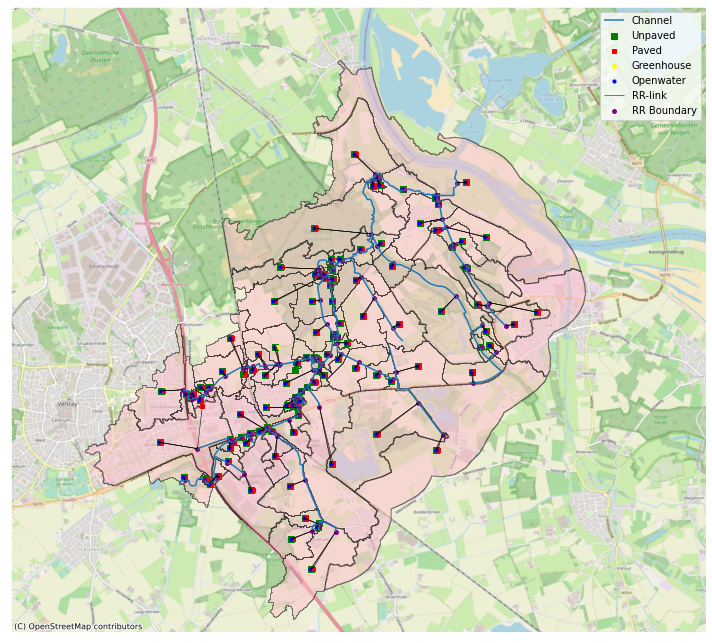

In [45]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(195000, 205000)
ax.set_ylim(390000, 399000)

hydamo.catchments.geometry.plot(ax=ax, label="Catchments", edgecolor="black", facecolor="pink", alpha=0.5)
hydamo.branches.geometry.plot(ax=ax, label="Channel")
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(
    ax=ax, markersize=30, marker="s", color="green", label="Unpaved"
)
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color="black", linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax, markersize=20, marker="s", color="red", label="Paved")
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color="black", linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax, markersize=15, color="yellow", label="Greenhouse")
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color="black", linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax, markersize=10, color="blue", label="Openwater")
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color="black", linewidth=0.5, label="RR-link")
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(
    ax=ax, markersize=15, color="purple", label="RR Boundary"
)

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor="pink", edgecolor="black", alpha=0.5)
cx.add_basemap(ax, crs=28992, source=cx.providers.OpenStreetMap.Mapnik)
ax.legend(handles=handles.append(poly), labels=labels.append("Catchments"))
fig.tight_layout()

## Writing the model

Now we call Hydrolib-core functionality to write the model. First, we initialize an object that converts all dataframes to Hydrolib-core objects. Then we add these models to the file structure of the FM model.

Call a function to convert the dataframes to Hydrolib-core classes:

In [46]:
models = Df2HydrolibModel(hydamo)

And add the classes to the file structure

In [47]:
fm.geometry.structurefile = [StructureModel(structure=models.structures)]
fm.geometry.crosslocfile = CrossLocModel(crosssection=models.crosslocs)
fm.geometry.crossdeffile = CrossDefModel(definition=models.crossdefs)

fm.geometry.frictfile = []
for i, fric_def in enumerate(models.friction_defs):
    fric_model = FrictionModel(global_=fric_def)
    fric_model.filepath = f"roughness_{i}.ini"
    fm.geometry.frictfile.append(fric_model)

fm.output.obsfile = [ObservationPointModel(observationpoint=models.obspoints)]

extmodel = ExtModel()
extmodel.boundary = models.boundaries_ext
extmodel.lateral = models.laterals_ext
fm.external_forcing.extforcefilenew = extmodel

fm.geometry.inifieldfile = IniFieldModel(initial=models.inifields)
# for ifield, onedfield in enumerate(models.onedfieldmodels):
#     fm.geometry.inifieldfile.initial[ifield].datafile = OneDFieldModel(
#         global_= onedfield
#     )

Now we write the file structure:

In [48]:
fm.filepath = Path(output_path) / "fm" / "test.mdu"
dimr = DIMR()
dimr.component.append(
    FMComponent(name="DFM", workingDir=Path(output_path) / "fm", model=fm, inputfile=fm.filepath)    
)
dimr.save(recurse=True)

In [49]:
import shutil
shutil.copy(data_path / "initialWaterDepth.ini", output_path / "fm")

'D:\\3640.20\\HYDROLIB-dhydamo\\hydrolib\\tests\\model2\\fm\\initialWaterDepth.ini'

This is not done yet. Use the delft3dfmpy writers for the RR-part:

In [50]:
if RTC:
    drtcmodel.write_xml_v1()

In [51]:
if RR:
    rr_writer = DRRWriter(drrmodel, output_dir=output_path, name="test", wwtp=(199000.0, 396000.0))
    rr_writer.write_all()

In [52]:
dimr = DIMRWriter(output_path=output_path)
dimr.write_dimrconfig(fm, rr_model=drrmodel, rtc_model=drtcmodel)
dimr.write_runbat()

In [53]:
print("Done!")

Done!


In [58]:
start = pd.to_datetime('2022-06-19 13:30:00')
piek = start + pd.to_timedelta(39135.,unit='minutes')

In [59]:
piek

Timestamp('2022-07-16 17:45:00')